In [1]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
from gym.envs.registration import registry, register
import pandas as pd
import random
from tqdm import tqdm
from typing_extensions import Self
import matplotlib.pyplot as plt

# rc('animation', html='jshtml')

/Users/atticusw/opt/anaconda3/lib/python3.9/site-packages/gym/envs/registration.py:307: DeprecationWarning: The package name gym_minigrid has been deprecated in favor of minigrid. Please uninstall gym_minigrid and install minigrid with `pip install minigrid`. Future releases will be maintained under the new package name minigrid.
  fn()


In [6]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
# elif torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
else:
    DEVICE = torch.device("cpu")

print(DEVICE)

class Config:
    """
    Stores algorithmic hyperparameters.
    """
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=True,
                clip_ratio=0.2,
                target_kl=0.01,
                fit_badly_coeff=0.05,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                use_gae=True,
                my_var=0):

        self.score_threshold = score_threshold # criterion for early stopping. If the rolling average reward (over the last 100 episodes) is greater than it, it ends.
        self.discount = discount # discount factor
        self.lr = lr # learning rate
        self.max_grad_norm = max_grad_norm # the maximum gradient norm (https://pytorch.org/docs/stable/generated/torch.nn.utils.clip_grad_norm_.html)
        self.log_interval = log_interval # logging interval
        self.max_episodes = max_episodes # the maximum number of episodes.
        self.use_critic = use_critic # whether to use critic or not.
        self.clip_ratio = clip_ratio # clip_ratio of PPO.
        self.target_kl = target_kl # target KL divergence for early stoping train_ac_iters for PPO
        self.fit_badly_coeff = fit_badly_coeff # the bound of approx. KL of when the model fits badly to the data.
        self.train_ac_iters = train_ac_iters # how many time to train ac_model using current computed old_logps
        self.gae_lambda=gae_lambda # lambda in Generalized Advantage Estimation (GAE)
        self.use_discounted_reward=use_discounted_reward # whether use discounted reward or not.
        self.entropy_coef = entropy_coef # entropy coefficient for PPO
        self.use_gae = use_gae # whether to use GAE or not.
        self.my_var = my_var # a variable for testing purposes.

cpu


In [3]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    """
    Initialize parameters of the network.
    m: torch.nn.Module
    """
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    """
    Convert observation into Torch.Tensor

    Parameters
    ----
    obss: dictionary or np.ndarray
    device: target device of torch.Tensor ('cpu', 'cuda')

    Return
    ----
    Torch Tensor
    """
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])

    return torch.tensor(images, device=device, dtype=torch.float)

class DoorKeyEnv5x5(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=5)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv6x6(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=6)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
    
class DoorKeyEnv8x8(DoorKeyEnv):
    def __init__(self):
        self.render_mode = "rgb_array"
        super().__init__(size=8)

    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

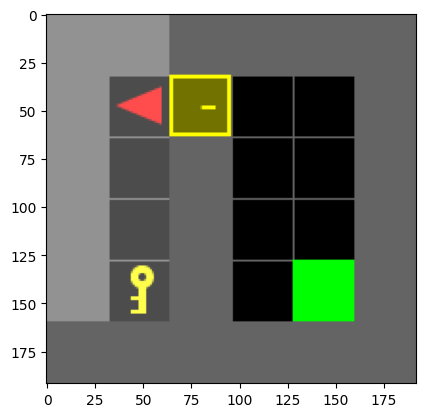

In [4]:
env = DoorKeyEnv6x6() # define environment.
env.reset()
action = env.action_space.sample()
obs, reward, terminated, truncated, info = env.step(action)

# get an RGB image corresponding to the whole environment or the agent's point of view (https://github.com/Farama-Foundation/Minigrid/blob/master/minigrid/minigrid_env.py#L716)
#            highlight (bool): If true, the agent's field of view or point of view is highlighted with a lighter gray color.
#            tile_size (int): How many pixels will form a tile from the NxM grid.
#            agent_pov (bool): If true, the rendered frame will only contain the point of view of the agent.
frame = env.get_frame(highlight=env.highlight, tile_size=env.tile_size, agent_pov=env.agent_pov)
# show an image to the notebook.
plt.imshow(frame)

In [7]:
class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=True):
        """
        Represents an Actor Crictic model that takes a 2d, multi-channeled
        image as input.

        Parameters
        ----
        num_actions : int

                      The action space of the environment.
                      The action space for DoorKey5x5 is 7-dimensional:
                      0: turn left,
                      1: turn right,
                      2: forward,
                      3: pickup an object,
                      4: drop an object,
                      5: activate an object,
                      6: done completing task

        use_critics : bool

                      Critic network will be used in forward pass if flag is set
                      to true.
        """
        super().__init__()
        self.use_critic = use_critic

        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            self.image_conv_critic = nn.Sequential(
                nn.Conv2d(3, 16, (2, 2)),
                nn.ReLU(),
                nn.MaxPool2d((2, 2)),
                nn.Conv2d(16, 32, (2, 2)),
                nn.ReLU(),
                nn.Conv2d(32, 64, (2, 2)),
                nn.ReLU()
            )
            self.critic = nn.Sequential(
                nn.Linear(64, 64),
                nn.Tanh(),
                nn.Linear(64, 1)
            )

        # Initialize parameters correctly
        self.apply(init_params)

    def forward(self, obs):
        """
        Performs a forward pass through the actor-critic network

        Parameters
        ----
        obs : int tensor. Shape [Batch size, ImWidth, ImHeight, Channels]

              input to the network.
        ----

        returns:

        dist : torch.distribution
            The distribution of actions from policy. A Categorical distribution
            for discreet action spaces.
        value : torch.Tensor (Batch size, 1)
            value output by critic network
        """
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into [b, c, h, w]

        dist, value = None, None

        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            y = self.image_conv_critic(conv_in)
            embedding = y.reshape(y.shape[0], -1)

            value = self.critic(embedding).squeeze(1)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        
        return dist, value

def compute_discounted_return(rewards, discount, device=DEVICE):
    """
		rewards: reward obtained at timestep.  Shape: (T,)
		discount: discount factor. float

    ----
    returns: sum of discounted rewards. Shape: (T,)
		"""
    returns = torch.zeros(*rewards.shape, device=device)

    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    return returns

def compute_advantage_gae(values, rewards, T, gae_lambda, discount):
    """
    Compute Adavantage with GAE. See Section 4.4.2 in the lecture notes.

    values: value at each timestep (T,)
    rewards: reward obtained at each timestep.  Shape: (T,)
    T: the number of frames, float
    gae_lambda: hyperparameter, float
    discount: discount factor, float

    -----

    returns:

    advantages : tensor.float. Shape [T,]

                 gae advantage term for timesteps 0 to T

    """
    advantages = torch.zeros_like(values)
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + discount * next_value  - values[i]
        advantages[i] = delta + discount * gae_lambda * next_advantage
    return advantages[:T]

In [8]:
class Machine:
    def __init__(self, num_actions=7, args=Config()):
        """
        A Machine object consists of a ACModel, its hyperparameters, and its history of rewards.

        Args:
            num_actions: size of action space
            args: Model hyperparameters
        """
        self.args = args
        self.model = ACModel(num_actions, use_critic=True).to(DEVICE)
        self.optim = torch.optim.Adam(self.model.parameters(), lr=self.args.lr)
        self.rewards = []

    def copy_machine(self, other: Self) -> None:
        """
        Copy state dict from 'other'. Reset rs.
        """
        state_dict = other.model.state_dict()
        for key, v in state_dict.items():
            self.model.state_dict()[key].copy_(v)
        self.rewards = []

    def avg_r(self) -> float:
        assert len(self.rewards) > 0, 'No rewards yet'
        return sum(self.rewards) / len(self.rewards)
    
    def collect_experiences(self, env:gym.Env):
        """
        Collects rollouts and computes advantages.

        Returns
        -------
        exps : dict
            Contains actions, rewards, advantages etc as attributes.
            Each attribute, e.g. `exps['reward']` has a shape
            (self.num_frames, ...).
        logs : dict
            Useful stats about the training process, including the average
            reward, policy loss, value loss, etc.
        """
        acmodel = self.model

        MAX_FRAMES_PER_EP = 300 # TODO: change this with different environments
        shape = (MAX_FRAMES_PER_EP, )

        actions = torch.zeros(*shape, device=DEVICE, dtype=torch.int)
        values = torch.zeros(*shape, device=DEVICE)
        rewards = torch.zeros(*shape, device=DEVICE)
        log_probs = torch.zeros(*shape, device=DEVICE)
        obss = [None]*MAX_FRAMES_PER_EP

        obs, _ = env.reset()

        total_return = 0

        T = 0

        while True:
            # Do one agent-environment interaction

            preprocessed_obs = preprocess_obss(obs, device=DEVICE)

            with torch.no_grad():
                dist, value = acmodel(preprocessed_obs)

            dist: Categorical
            action = dist.sample()[0]

            obss[T] = obs
            obs, reward, done, _, _ = env.step(action.item())


            # Update experiences values
            actions[T] = action
            values[T] = value
            rewards[T] = reward
            log_probs[T] = dist.log_prob(action)


            total_return += reward
            T += 1

            if done or T>=MAX_FRAMES_PER_EP-1:
                break

        discounted_reward = compute_discounted_return(rewards[:T], self.args.discount, DEVICE)
        exps = dict(
            obs = preprocess_obss([
                obss[i]
                for i in range(T)
            ], device=DEVICE),
            action = actions[:T],
            value  = values[:T],
            reward = rewards[:T],
            log_prob = log_probs[:T],
            discounted_reward = discounted_reward,
            T = T
        )

        logs = {
            "return_per_episode": total_return,
            "num_frames": T
        }

        return exps, logs

    def _compute_policy_loss_ppo(self, obs, init_logp, old_logp, actions, advantages):
        """
        Computes the policy loss for PPO.

        obs: observeration to pass into acmodel. shape: (T,)
        init_logp: log probabilities we get from the agent performing the action. shape: (T,)
        old_logp: log probabilities from previous timestep. shape: (T,)
        actions: action at this timestep. shape: (T,ImWidth,ImHeight,Channels)
        advantages: the computed advantages. shape: (T,)

        ---
        Returns:

        policy_loss: ppo policy loss as shown in line 6 of PPO alg. tensor.float. Shape (,1)
        fit_badly: an approximation of kl divergence between init_logp and old_logp. tensor.float. Shape (,1)
        approx_kl: an approximation of kl divergence between old_logp and new_logp. tensor.float. Shape (,1)
        """
        policy_loss, approx_kl = 0, 0
        dist, _ = self.model(obs)
        dist: Categorical

        entropy = dist.entropy()
        logps = dist.log_prob(actions)
        r_terms = torch.exp(logps - old_logp)
        ppo_loss = torch.min(r_terms * advantages, torch.clamp(r_terms, 1 - self.args.clip_ratio, 1 + self.args.clip_ratio) * advantages)
        
        # Importance sampling factor
        factors = torch.exp(old_logp - init_logp)
        
        indices = factors < 100

        policy_loss_tensor = factors * ppo_loss + self.args.entropy_coef * entropy
        policy_loss = - torch.mean(policy_loss_tensor[indices])

        # approx_kl = torch.sum(torch.exp(old_logp) * (old_logp - logps)) / torch.sum(torch.exp(old_logp))
        approx_kl = torch.mean((old_logp - logps) ** 2) / 2
        fit_badly = torch.mean((old_logp - init_logp) ** 2)

        return policy_loss, fit_badly, approx_kl
    
    def _compute_value_loss(self, obs, returns):
        _, value = self.model(obs)
        value_loss = torch.mean((value - returns) ** 2)
        return value_loss

In [39]:
class MachineCluster:
    def __init__(self, hps:list[str], num_machines:int=5, num_survivors:int=2):
        """
        hps: A list of hyperparameters to optimize. Must be a subset of keys in Machine.args.
        num_machines: The number of machines in the cluster.
        num_survivors: The number of survivors to select from the cluster.
        """
        self.num_machines = num_machines
        self.num_survivors = num_survivors
        self.hps = hps
        self.machines = []
        for _ in range(self.num_machines):
            self.machines.append(Machine(num_actions=7, args=Config()))

        # now let's say hps = ['entropy_coef']
        for hp in hps:
            values = np.random.uniform(0, 0.5, size=num_machines)
            # TODO: Should it be other distributions?
            self.update_hp(hp, values)

    def update_hp(self, hp:str, targets:list[float]) -> None:
        """
        Update the hyperparameters of the models in the cluster.

        Args:
            hp: The hyperparameter to update.
            targets: The target hyperparameter values. Has length self.num_models.
        """
        for i in range(self.num_machines):
            setattr(self.machines[i].args, hp, targets[i])

    def get_hps(self, hp:str) -> list[float]:
        """
        Get the hyperparameters of the models in the cluster.

        Args:
        - hp: str, element of self.hps.

        Returns:
        - ooooo: A list of hp of each model.
        """
        ooooo = [getattr(self.machines[i].args, hp) for i in range(self.num_machines)]
        return ooooo
    
    def generate_data(self, num_trajs:int=4):
        """
        Generate batches of data for training the models.

        Return:
            trajs: list of exps.  
        """

        trajs = []

        for i in range(self.num_machines):
            for _ in range(num_trajs):
                exps, _ = self.machines[i].collect_experiences(env)
                trajs.append(exps)
            
            # print(f'Generated data for machine {i}.')
        
        return trajs
    
    def train_one_step(self, data, batch_size=4):
        """
        Do at most self.args.train_ac_iters step of optimization on each model in the cluster.

        Args:
            data: list of exps.
            batch_size: number of trajectories used in each gradient step.

        Return:
            logs: list of length self.num_machines. Each element is a list of dictionaries containing policy_loss and value_loss.
        """
        # TODO: actually do this

        MAX_FRAMES_PER_EP = 300

        logs = [[]] * self.num_machines
        fit_badly_counter = False
        
        for machine_idx in range(self.num_machines):

            machine = self.machines[machine_idx]

            total_policy_loss = 0
            total_value_loss = 0
            fit_badly_count = 0

            # select random subset of data
            idx = np.random.choice(len(data), batch_size, replace=False)

            for i in idx:
                sb = data[i]
                T = sb['T']
                obs = sb['obs']
                dist, values = machine.model(obs)
                init_logp = sb['log_prob']
                old_logp = dist.log_prob(sb['action']).detach()

                # add 0 to end of values until it has length MAX_FRAMES_PER_EP
                values_extended = torch.cat([values, torch.zeros((MAX_FRAMES_PER_EP - len(values), ), device=DEVICE)], dim=0)
                full_reward = torch.cat([sb['reward'], torch.zeros((MAX_FRAMES_PER_EP - len(sb['reward']), ), device=DEVICE)], dim=0)
                assert len(values_extended) == MAX_FRAMES_PER_EP
                assert len(full_reward) == MAX_FRAMES_PER_EP
                
                # compute advantage
                if machine.args.use_gae:
                    advantage = compute_advantage_gae(values_extended, full_reward, T, machine.args.gae_lambda, machine.args.discount)
                else:
                    advantage = sb['discounted_reward'] - values.reshape(-1)
                
                # compute policy and value loss
                policy_loss, fit_badly, approx_kl = machine._compute_policy_loss_ppo(obs, init_logp, old_logp, sb['action'], advantage)

                value_loss = machine._compute_value_loss(obs, sb['discounted_reward'])
                
                if fit_badly < machine.args.fit_badly_coeff:
                    total_policy_loss += policy_loss
                    total_value_loss += value_loss
                else:
                    fit_badly_count += 1
            
            if random.random() < 0.03:
                print(fit_badly_count / (batch_size * self.num_machines))
            
            machine.optim.zero_grad()
            loss = torch.tensor(total_policy_loss + total_value_loss, dtype=torch.float32, device=DEVICE).requires_grad_()
            loss.backward()
            machine.optim.step()
            
            logs[machine_idx].append({
            "policy_loss": total_policy_loss,
            "value_loss": total_value_loss
            })

            if fit_badly_count / (batch_size * self.num_machines) > 0.3:
                fit_badly_counter = True
        
        return logs, fit_badly_counter

    def train(self, data, batch_size=4, max_steps=25):
        """
        Train each model in the cluster until data fits poorly, or until reaches max_steps.

        Return:
        logs: list of length self.num_machines. Each element is a list of dictionaries containing policy_loss and value_loss.
        """ 

        logs = [[]] * self.num_machines
        steps = 0
        fit_badly_counter = False
    
        while not fit_badly_counter:
            if steps >= max_steps:
                break
            new_logs, fit_badly_counter = self.train_one_step(data, batch_size)
            logs = [[*i, *j] for i, j in zip(logs, new_logs)]
            steps += 1
        
        return logs
        
    def evaluate(self) -> list[float]:
        """
        Evaluate the performance of the models in the cluster.

        Args:
        - trained_models: list of Machines.

        Returns:
        - performances: list of floats. The average return of each model.
        """

        performances = []

        for machine in self.machines:
            total_rewards = 0
            for i in range(10):
                _, logs = machine.collect_experiences(env)
                total_rewards += logs['return_per_episode']
            machine.rewards.append(total_rewards / 10)
            performances.append(total_rewards / 10)

        return performances
        
    def reproduce(self, performances) -> None:
        """
        Select and reproduce the survivors.
        Also shift hyperparams.
        """

        survivors = torch.topk(torch.tensor(performances, device=DEVICE), self.num_survivors).indices
        logits = torch.tensor([performances[x] if x in survivors else float('-inf') for x in range(self.num_machines)])
        dist = torch.distributions.Categorical(logits=logits)

        for i in range(self.num_machines):
            if i not in survivors:
                self.machines[i].copy_machine(self.machines[dist.sample().item()])
        
        for hp in self.hps:
            new_hps = self.get_hps(hp)
            for i in range(self.num_machines):
                new_hps[i] += np.random.normal(0, 0.05)
                if new_hps[i] < 0:
                    new_hps[i] = 0.01
                if new_hps[i] > 0.5:
                    new_hps[i] = 0.5
            print(new_hps)
            self.update_hp(hp, new_hps)

In [38]:
def run_cluster_experiment(hps:list[str], 
                           num_machines:int=5, 
                           num_survivors:int=2, 
                           num_trajs:int=4, 
                           num_iters:int=200,
                           batch_size:int=4,
                           max_steps:int=5, 
                           seed=42):
    """
    Run the cluster experiment.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    cluster = MachineCluster(hps = hps, num_machines = num_machines, num_survivors = num_survivors)

    pbar = tqdm(range(num_iters))
    logs = [[]] * num_machines

    for iter in pbar:
        data = cluster.generate_data(num_trajs=num_trajs)
        _ = cluster.train(data=data, batch_size=batch_size, max_steps=max_steps)
        performances = cluster.evaluate()
        logs = [[*i, j] for i, j in zip(logs, performances)]
        cluster.reproduce(performances)

        print(f'Iteration {iter} done!')

    # return pd.DataFrame(pdlogs).set_index('epoch')
    return logs, cluster.machines

In [40]:
logs, trained_machines = run_cluster_experiment(hps=['entropy_coef'])

# df.plot(x='num_frames', y=['reward', 'smooth_reward'])

  0%|          | 0/200 [00:00<?, ?it/s]/var/folders/8m/r3kmm3xs1lngf9bhwg216mlc0000gn/T/ipykernel_41554/1551278119.py:128: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = torch.tensor(total_policy_loss + total_value_loss, dtype=torch.float32, device=DEVICE).requires_grad_()


0.05
0.0
0.15
0.0


  0%|          | 1/200 [00:39<2:11:29, 39.65s/it]

[0.12809140102645436, 0.48680567481647996, 0.3490276562467927, 0.2585656952724221, 0.11296393931421772]
Iteration 0 done!


  1%|          | 2/200 [01:17<2:08:16, 38.87s/it]

[0.15808623271200467, 0.4863661470013122, 0.3715982161791676, 0.2993582762968766, 0.14130173566015902]
Iteration 1 done!


  2%|▏         | 3/200 [01:58<2:10:09, 39.64s/it]

[0.17956714366863397, 0.4967505313594678, 0.38517715803893626, 0.23552084750586114, 0.08724890863974591]
Iteration 2 done!


  2%|▏         | 4/200 [02:34<2:04:15, 38.04s/it]

[0.23222478633527915, 0.5, 0.40578807815113294, 0.23137830176556654, 0.06859064952908606]
Iteration 3 done!
0.0
0.0


  2%|▎         | 5/200 [03:12<2:03:30, 38.00s/it]

[0.21298269223792288, 0.5, 0.38385871783826814, 0.289693439127406, 0.09701269984189378]
Iteration 4 done!
0.0


  3%|▎         | 6/200 [03:52<2:05:53, 38.93s/it]

[0.24296239790199758, 0.3787879869863529, 0.4280609876563206, 0.3265356339820277, 0.08294632198598312]
Iteration 5 done!


  4%|▎         | 7/200 [04:30<2:04:12, 38.61s/it]

[0.1592401847106128, 0.3339785138705199, 0.4017462610949719, 0.4018265483640105, 0.14945547630129385]
Iteration 6 done!


  4%|▍         | 8/200 [05:05<2:00:02, 37.51s/it]

[0.2255886112634466, 0.34089344835981045, 0.3847505358065111, 0.5, 0.09983756197676816]
Iteration 7 done!


  4%|▍         | 9/200 [05:52<2:08:16, 40.30s/it]

[0.22591258547448242, 0.40853550709447406, 0.3744931243566177, 0.47647955537342895, 0.10119026401121572]
Iteration 8 done!


  5%|▌         | 10/200 [06:42<2:16:51, 43.22s/it]

[0.23100562079347509, 0.3469620696647636, 0.43986733383378496, 0.42151814285552175, 0.08359905539435464]
Iteration 9 done!
0.0


  6%|▌         | 11/200 [07:22<2:13:23, 42.35s/it]

[0.19900602995460262, 0.3386509954292561, 0.5, 0.4284103680995609, 0.0484626545987227]
Iteration 10 done!
0.0
0.0


  6%|▌         | 12/200 [07:59<2:07:37, 40.73s/it]

[0.138771365813197, 0.2968867101497182, 0.5, 0.425661310934516, 0.025171550652742243]
Iteration 11 done!
0.0


  6%|▋         | 13/200 [08:39<2:06:16, 40.51s/it]

[0.11831553513043441, 0.295961479988235, 0.5, 0.447017997368899, 0.01]
Iteration 12 done!
0.0


  7%|▋         | 14/200 [09:17<2:03:39, 39.89s/it]

[0.16407027210958192, 0.2316234152555982, 0.5, 0.4399345081010688, 0.01]
Iteration 13 done!
0.0


  8%|▊         | 15/200 [09:58<2:03:35, 40.08s/it]

[0.19557771093097498, 0.13778747872146135, 0.5, 0.4839487620502579, 0.03943263396912174]
Iteration 14 done!
0.0


  8%|▊         | 16/200 [10:41<2:05:10, 40.82s/it]

[0.1913813481873412, 0.17328764167331406, 0.5, 0.5, 0.04677844780101822]
Iteration 15 done!
0.0


  8%|▊         | 17/200 [11:15<1:58:29, 38.85s/it]

[0.256130627428189, 0.20049865929033142, 0.5, 0.5, 0.023719961199287272]
Iteration 16 done!
0.0


  9%|▉         | 18/200 [11:49<1:54:01, 37.59s/it]

[0.293958861173846, 0.21419152331028768, 0.4356183901777233, 0.5, 0.018675692421983747]
Iteration 17 done!


 10%|▉         | 19/200 [12:25<1:51:11, 36.86s/it]

[0.34831397927463315, 0.2299537696388304, 0.43353792462805707, 0.5, 0.01]
Iteration 18 done!
0.0
0.0


 10%|█         | 20/200 [12:59<1:48:05, 36.03s/it]

[0.4052958698753347, 0.2261315132774055, 0.39576874576086984, 0.4278891763065973, 0.042400159257702]
Iteration 19 done!
0.0
0.0
0.0


 10%|█         | 21/200 [13:33<1:45:51, 35.48s/it]

[0.44045299698633494, 0.2527918791723711, 0.40403892877585507, 0.3587882978719754, 0.018219302279930162]
Iteration 20 done!
0.0
0.0


 11%|█         | 22/200 [14:12<1:48:53, 36.71s/it]

[0.48254203572553556, 0.2268585431913106, 0.4466990060284328, 0.360259827455853, 0.04405152457672853]
Iteration 21 done!


 12%|█▏        | 23/200 [14:50<1:48:49, 36.89s/it]

[0.49065976376635945, 0.17399241305070562, 0.4399960283376763, 0.3391721038753831, 0.07813357275875278]
Iteration 22 done!
0.0
0.0


 12%|█▏        | 24/200 [15:24<1:45:29, 35.97s/it]

[0.4524314146062246, 0.21950320223394287, 0.43081961972981864, 0.2787121683134028, 0.08097065692359376]
Iteration 23 done!


 12%|█▎        | 25/200 [16:01<1:46:23, 36.48s/it]

[0.4413075079412317, 0.22290934474097546, 0.45500856142995755, 0.30627887911789, 0.12489333557351574]
Iteration 24 done!
0.0


 13%|█▎        | 26/200 [16:39<1:46:43, 36.80s/it]

[0.3905887601421342, 0.16092746200498642, 0.36313075135495987, 0.4116119027011118, 0.21670854318917795]
Iteration 25 done!


 14%|█▎        | 27/200 [17:15<1:45:18, 36.52s/it]

[0.4551240359077407, 0.23074483720057865, 0.35013155509232463, 0.4130333158866977, 0.17000083283670087]
Iteration 26 done!
0.0


 14%|█▍        | 28/200 [17:49<1:43:11, 36.00s/it]

[0.5, 0.20560139951703085, 0.4090748519441716, 0.47859143071687854, 0.2132043319436482]
Iteration 27 done!


 14%|█▍        | 29/200 [18:19<1:37:11, 34.10s/it]

[0.49267536427107794, 0.21934303988202697, 0.4587948540486006, 0.46521568883483455, 0.2729673403952216]
Iteration 28 done!


 15%|█▌        | 30/200 [18:48<1:31:48, 32.40s/it]

[0.40871867149534713, 0.21371981106070126, 0.38303818834371944, 0.4059695284899515, 0.3318888566773332]
Iteration 29 done!


 16%|█▌        | 31/200 [19:12<1:24:42, 30.07s/it]

[0.33220471469885776, 0.20759801157333138, 0.3376130627681099, 0.4361749012619037, 0.251030262175056]
Iteration 30 done!


 16%|█▌        | 32/200 [19:36<1:19:01, 28.23s/it]

[0.3495203502101021, 0.16619665261394845, 0.37344834688004536, 0.3653792447850598, 0.18246455336974982]
Iteration 31 done!


 16%|█▋        | 33/200 [20:13<1:25:33, 30.74s/it]

[0.3135132202020867, 0.20154752776182872, 0.35929953303100787, 0.4180176917656391, 0.2077200839739035]
Iteration 32 done!


 17%|█▋        | 34/200 [20:37<1:19:28, 28.72s/it]

[0.4030871872202936, 0.13471704891437963, 0.38675112976254183, 0.4152045060843366, 0.25342440360537993]
Iteration 33 done!


 18%|█▊        | 35/200 [21:01<1:15:24, 27.42s/it]

[0.44341934305643105, 0.12329545286106171, 0.35003733119807084, 0.3825529773114339, 0.2201344101002914]
Iteration 34 done!
0.0


 18%|█▊        | 36/200 [21:26<1:12:44, 26.61s/it]

[0.49667850206261305, 0.12868345563368885, 0.33754264440746856, 0.39716041941737384, 0.2341462074004161]
Iteration 35 done!


 18%|█▊        | 37/200 [21:50<1:10:03, 25.79s/it]

[0.5, 0.18754843378374417, 0.3455244758350694, 0.4214151709725339, 0.26938451683753073]
Iteration 36 done!


 19%|█▉        | 38/200 [22:14<1:08:25, 25.34s/it]

[0.45622770720729516, 0.21112485799250613, 0.33277949506062715, 0.388992170425413, 0.2809526330545953]
Iteration 37 done!
0.0
0.0


 20%|█▉        | 39/200 [22:38<1:07:13, 25.05s/it]

[0.48760724382149745, 0.26243681208742997, 0.32015312872008383, 0.3794811063185489, 0.3072827437721838]
Iteration 38 done!


 20%|██        | 40/200 [23:02<1:06:01, 24.76s/it]

[0.5, 0.21300232614508371, 0.27846289810071845, 0.330885422332031, 0.3359532684669455]
Iteration 39 done!
0.0


 20%|██        | 41/200 [23:27<1:05:15, 24.62s/it]

[0.44208284832189354, 0.12675657694912623, 0.2941606824392496, 0.29710585097669584, 0.2543807151162147]
Iteration 40 done!
0.0
0.0
0.0


 21%|██        | 42/200 [23:51<1:04:15, 24.40s/it]

[0.5, 0.1830402037833266, 0.21747397735574053, 0.3196391603750024, 0.2428190865566843]
Iteration 41 done!


 22%|██▏       | 43/200 [24:16<1:04:19, 24.58s/it]

[0.4822446763242366, 0.171817368633248, 0.31169552825100555, 0.28793958745196574, 0.24548952125393975]
Iteration 42 done!


 22%|██▏       | 44/200 [24:40<1:03:53, 24.57s/it]

[0.41663686623577467, 0.14687872651658906, 0.2848186631586396, 0.3028247638927051, 0.20429665175245593]
Iteration 43 done!


 22%|██▎       | 45/200 [25:04<1:02:58, 24.38s/it]

[0.38145945239434365, 0.1859406461391575, 0.22393749102061938, 0.3614559630188271, 0.306878961302678]
Iteration 44 done!
0.0
0.0


 23%|██▎       | 46/200 [25:28<1:02:17, 24.27s/it]

[0.38686502294596686, 0.2335958265221151, 0.14506946066096124, 0.3640787763789972, 0.3140507181529463]
Iteration 45 done!
0.0
0.0


 24%|██▎       | 47/200 [25:53<1:02:34, 24.54s/it]

[0.3770897803951847, 0.2731817194483793, 0.19314549058901467, 0.3819424544811203, 0.314194436695244]
Iteration 46 done!
0.0
0.0


 24%|██▍       | 48/200 [26:18<1:02:16, 24.58s/it]

[0.3952905524683828, 0.24930908308690847, 0.1912062161402771, 0.42896722589327174, 0.22505699749939734]
Iteration 47 done!


 24%|██▍       | 49/200 [26:42<1:01:35, 24.47s/it]

[0.44406406830525824, 0.1993443927055919, 0.14314269118275336, 0.4357352251978826, 0.22095546568393942]
Iteration 48 done!


 25%|██▌       | 50/200 [27:21<1:11:40, 28.67s/it]

[0.48123224638060397, 0.21344110786585, 0.16596759294528565, 0.4706564819171012, 0.24396534974544148]
Iteration 49 done!


 26%|██▌       | 51/200 [27:49<1:10:49, 28.52s/it]

[0.5, 0.12340349609534038, 0.15503365134665137, 0.38538793456246395, 0.25797943144734714]
Iteration 50 done!


 26%|██▌       | 52/200 [28:18<1:10:50, 28.72s/it]

[0.5, 0.04024258104297404, 0.1637661972415414, 0.3650952135786282, 0.2340949387028425]
Iteration 51 done!


 26%|██▋       | 53/200 [28:53<1:14:51, 30.56s/it]

[0.5, 0.16605530198431143, 0.20160248425542196, 0.38662293006054027, 0.23743121466061615]
Iteration 52 done!


 27%|██▋       | 54/200 [29:27<1:16:50, 31.58s/it]

[0.5, 0.23401987320113693, 0.15060404831703753, 0.39465103597541124, 0.2656220426299414]
Iteration 53 done!
0.0


 28%|██▊       | 55/200 [29:55<1:14:08, 30.68s/it]

[0.4700055199083011, 0.20948381692735416, 0.16304080202064777, 0.3394987136015939, 0.22622725734604912]
Iteration 54 done!
0.0
0.0


 28%|██▊       | 56/200 [30:26<1:13:26, 30.60s/it]

[0.4587348650648665, 0.19698779417136883, 0.12866000306270875, 0.34537894581163353, 0.26891524453720483]
Iteration 55 done!
0.0


 28%|██▊       | 57/200 [30:52<1:09:57, 29.35s/it]

[0.4131869562927026, 0.26283178609479296, 0.1327476403859332, 0.34755329224182363, 0.2550614501344073]
Iteration 56 done!
0.0


 29%|██▉       | 58/200 [31:19<1:07:24, 28.48s/it]

[0.3841138283296813, 0.22925719207416778, 0.13474516448235194, 0.4347548675244843, 0.27536908576712943]
Iteration 57 done!


 30%|██▉       | 59/200 [31:47<1:06:45, 28.41s/it]

[0.4513044840027456, 0.27444639896538114, 0.12210419871595989, 0.3757649870593606, 0.26869438176373717]
Iteration 58 done!


 30%|███       | 60/200 [32:12<1:04:14, 27.53s/it]

[0.4028204157054022, 0.23289400654982623, 0.18987897535971027, 0.4779170992328765, 0.29907596973114414]
Iteration 59 done!


 30%|███       | 61/200 [32:40<1:03:46, 27.53s/it]

[0.35443759429097615, 0.21773096766649092, 0.14147648558222548, 0.4496394611127553, 0.30912225505940644]
Iteration 60 done!


 31%|███       | 62/200 [33:15<1:08:19, 29.71s/it]

[0.3800178488094272, 0.1817318807807403, 0.11355696370961041, 0.5, 0.39058266099977673]
Iteration 61 done!
0.0


 32%|███▏      | 63/200 [33:48<1:10:00, 30.66s/it]

[0.2946990904993513, 0.13306668619610143, 0.17415466634285123, 0.4637082847931271, 0.36591476254685107]
Iteration 62 done!


 32%|███▏      | 64/200 [34:18<1:09:35, 30.70s/it]

[0.2991991046482175, 0.25455448748628373, 0.2424159697268596, 0.4718077019759376, 0.3518462357704889]
Iteration 63 done!
0.0


 32%|███▎      | 65/200 [34:48<1:08:19, 30.37s/it]

[0.31526160083275856, 0.21765957073036823, 0.27856511029571907, 0.5, 0.2975558650951622]
Iteration 64 done!


 33%|███▎      | 66/200 [35:16<1:06:04, 29.59s/it]

[0.35928732954258247, 0.16715978395807993, 0.2080677902012404, 0.4151632028624478, 0.225435466083361]
Iteration 65 done!
0.0


 34%|███▎      | 67/200 [35:45<1:05:18, 29.46s/it]

[0.40257658514320127, 0.1638251829328217, 0.24963635708600782, 0.5, 0.22454247709288305]
Iteration 66 done!


 34%|███▍      | 68/200 [36:14<1:04:46, 29.44s/it]

[0.33172534833850315, 0.14919175231228124, 0.22700340125611637, 0.4844837271335687, 0.2671852990629713]
Iteration 67 done!
0.0


 34%|███▍      | 69/200 [36:40<1:02:00, 28.40s/it]

[0.25143902230817644, 0.1469819655645094, 0.1666006699161879, 0.491493335523578, 0.22921104200807313]
Iteration 68 done!
0.0


 35%|███▌      | 70/200 [37:06<1:00:01, 27.70s/it]

[0.24892550049457154, 0.21171363075151586, 0.1967257184066313, 0.5, 0.18514635532357274]
Iteration 69 done!


 36%|███▌      | 71/200 [37:37<1:01:39, 28.67s/it]

[0.2533310085602499, 0.13065511388634102, 0.25190297178286, 0.5, 0.2336810560722805]
Iteration 70 done!


 36%|███▌      | 72/200 [38:03<59:33, 27.92s/it]  

[0.22139844280591786, 0.12377110439246611, 0.21276205860428052, 0.4471947675375967, 0.238473900087253]
Iteration 71 done!
0.0


 36%|███▋      | 73/200 [38:28<56:51, 26.86s/it]

[0.23465379753153, 0.10074493333440042, 0.19585272275515708, 0.41839350901376327, 0.3343368768124566]
Iteration 72 done!
0.0


 37%|███▋      | 74/200 [38:51<54:20, 25.88s/it]

[0.30784883684024617, 0.09530223929776536, 0.20425400284313366, 0.38067727708644294, 0.26809758129249533]
Iteration 73 done!
0.0


 38%|███▊      | 75/200 [39:15<52:34, 25.24s/it]

[0.2571549483708082, 0.1626958425323977, 0.17876180337820444, 0.43273717387410704, 0.20977535412007614]
Iteration 74 done!


 38%|███▊      | 76/200 [39:39<51:19, 24.83s/it]

[0.22402578370945592, 0.25097390141376075, 0.16640253511048372, 0.42662706632206987, 0.2702944845731643]
Iteration 75 done!


 38%|███▊      | 77/200 [40:16<58:06, 28.35s/it]

[0.186098989633408, 0.10798131830406674, 0.1360546867097274, 0.35861050529273536, 0.22413082875734894]
Iteration 76 done!


 39%|███▉      | 78/200 [41:00<1:07:16, 33.08s/it]

[0.11999257783089189, 0.09213596587378164, 0.21443720469910257, 0.3078866307419202, 0.2831629903403713]
Iteration 77 done!
0.0
0.0


 40%|███▉      | 79/200 [41:38<1:09:50, 34.63s/it]

[0.10984712890172883, 0.11279723835808342, 0.11689883833052749, 0.2664316281361149, 0.3127289983690635]
Iteration 78 done!
0.0


 40%|████      | 80/200 [42:24<1:15:57, 37.98s/it]

[0.06244093158010171, 0.16910568381505264, 0.10008461995557771, 0.34154758156483866, 0.268066353189545]
Iteration 79 done!


 40%|████      | 81/200 [42:59<1:13:44, 37.18s/it]

[0.1253783144511859, 0.1986582127730137, 0.04426288586418816, 0.32382733239781747, 0.34208489068882864]
Iteration 80 done!


 41%|████      | 82/200 [43:35<1:12:30, 36.87s/it]

[0.1073459215765966, 0.13533805486439704, 0.04795814484819337, 0.25779011826677223, 0.3246898185424888]
Iteration 81 done!
0.0


 42%|████▏     | 83/200 [44:10<1:10:54, 36.36s/it]

[0.09142574287389195, 0.171702023661255, 0.04715445054008964, 0.2541869077417465, 0.275344187192323]
Iteration 82 done!


 42%|████▏     | 84/200 [44:47<1:10:33, 36.50s/it]

[0.0925840468769969, 0.20096998566459193, 0.07999967167430629, 0.23211788231557676, 0.2648589011113823]
Iteration 83 done!
0.0
0.0
0.0


 42%|████▎     | 85/200 [45:24<1:10:02, 36.54s/it]

[0.0046732467167697744, 0.18058471385308078, 0.07446871774686553, 0.32034463851948486, 0.21884431857817555]
Iteration 84 done!
0.0


 43%|████▎     | 86/200 [45:59<1:08:50, 36.23s/it]

[0.044117225772980356, 0.11934234774612881, 0.01798178797253873, 0.3030360575245802, 0.285376278631261]
Iteration 85 done!
0.0


 44%|████▎     | 87/200 [46:34<1:07:03, 35.61s/it]

[0.11954616813508698, 0.13709325629086072, 0.04241495626358724, 0.339861411886236, 0.3141696663933136]
Iteration 86 done!


 44%|████▍     | 88/200 [47:07<1:05:19, 35.00s/it]

[0.1373823821570166, 0.1738197172120851, 0.12516706733702385, 0.2974778144254842, 0.24431691523596494]
Iteration 87 done!
0.0
0.0


 44%|████▍     | 89/200 [47:54<1:11:06, 38.44s/it]

[0.04783360524989447, 0.13136502715742693, 0.12325166435023616, 0.24881512769607428, 0.2673942176737749]
Iteration 88 done!
0.0


 45%|████▌     | 90/200 [48:34<1:11:28, 38.99s/it]

[0.08293802372243722, 0.1441734901518599, 0.09199197693458588, 0.27461713058767256, 0.3181882595777758]
Iteration 89 done!


 46%|████▌     | 91/200 [49:11<1:09:36, 38.32s/it]

[0.09594017886936038, 0.15630604068382425, 0.11671296695991137, 0.29506399104770703, 0.4078633850543576]
Iteration 90 done!


 46%|████▌     | 92/200 [49:47<1:07:53, 37.72s/it]

[0.17883313056418415, 0.22919956908139805, 0.11001404325947148, 0.29515073784140067, 0.4333467488275375]
Iteration 91 done!


 46%|████▋     | 93/200 [50:21<1:05:09, 36.54s/it]

[0.21620264849383858, 0.22670253836731033, 0.1699033401568336, 0.22176007321645458, 0.5]
Iteration 92 done!
0.0
0.0


 47%|████▋     | 94/200 [51:02<1:07:03, 37.95s/it]

[0.2533095946628702, 0.2253734675299961, 0.24735197563151326, 0.2849507288680071, 0.5]
Iteration 93 done!


 48%|████▊     | 95/200 [51:52<1:12:34, 41.47s/it]

[0.22180863197576095, 0.2939227139210024, 0.2470215111805486, 0.22446633035773889, 0.44414745661504396]
Iteration 94 done!
0.0


 48%|████▊     | 96/200 [52:33<1:12:01, 41.55s/it]

[0.1473079329756256, 0.27355912361123114, 0.25998805974789285, 0.25080660742083866, 0.4169239629520478]
Iteration 95 done!


 48%|████▊     | 97/200 [53:10<1:08:59, 40.18s/it]

[0.180901238577986, 0.3906941154240535, 0.2862215402342512, 0.24517876580677828, 0.43050359508941055]
Iteration 96 done!
0.0


 49%|████▉     | 98/200 [53:47<1:06:25, 39.08s/it]

[0.23667208062515693, 0.3411305227313436, 0.2630641267102053, 0.2470658922542884, 0.4501968879058403]
Iteration 97 done!


 50%|████▉     | 99/200 [54:28<1:06:36, 39.57s/it]

[0.15798490921215969, 0.3959864243219473, 0.28335581429231627, 0.330074691619326, 0.5]
Iteration 98 done!


 50%|█████     | 100/200 [55:09<1:07:00, 40.20s/it]

[0.18536215250484367, 0.48055443238394724, 0.4022457800307259, 0.35034467368701666, 0.43408984953887864]
Iteration 99 done!
0.0


 50%|█████     | 101/200 [55:46<1:04:45, 39.24s/it]

[0.15570189620887398, 0.5, 0.3433303495199654, 0.2685442447294536, 0.4461511128796366]
Iteration 100 done!
0.0


 51%|█████     | 102/200 [56:21<1:01:50, 37.86s/it]

[0.18733606505732292, 0.5, 0.28166436270154965, 0.3140051907835805, 0.38232698654631203]
Iteration 101 done!
0.0
0.0


 52%|█████▏    | 103/200 [56:56<59:56, 37.08s/it]  

[0.09774297804368716, 0.45220929087042244, 0.2087547384857003, 0.3002987309290801, 0.3605259416372752]
Iteration 102 done!
0.0


 52%|█████▏    | 104/200 [57:34<59:33, 37.23s/it]

[0.07370515270733548, 0.42496263687715263, 0.17156420555401294, 0.3130899294208766, 0.4008814271654959]
Iteration 103 done!


 52%|█████▎    | 105/200 [58:16<1:01:08, 38.61s/it]

[0.03479722098404679, 0.5, 0.1537609134038779, 0.2833258962544232, 0.34598148028263476]
Iteration 104 done!
0.0


 53%|█████▎    | 106/200 [58:50<58:28, 37.32s/it]  

[0.07292885351114041, 0.5, 0.11012417239841402, 0.2786549864469195, 0.30746041771529575]
Iteration 105 done!


 54%|█████▎    | 107/200 [59:31<59:46, 38.56s/it]

[0.07388111152161157, 0.5, 0.03819232158662654, 0.2850103346956739, 0.2783718824655301]
Iteration 106 done!
0.0


 54%|█████▍    | 108/200 [1:00:02<55:16, 36.05s/it]

[0.15587840895930746, 0.5, 0.01, 0.3343232416052936, 0.2978415788035319]
Iteration 107 done!


 55%|█████▍    | 109/200 [1:00:28<50:15, 33.14s/it]

[0.11440164473628339, 0.5, 0.01, 0.3482380439097311, 0.2119430204742783]
Iteration 108 done!
0.0
0.0


 55%|█████▌    | 110/200 [1:00:59<48:39, 32.44s/it]

[0.020134705462595326, 0.4148867440499559, 0.01944175340529752, 0.3111893129532083, 0.21924550515345997]
Iteration 109 done!
0.0


 56%|█████▌    | 111/200 [1:01:23<44:28, 29.98s/it]

[0.01, 0.4199235177821966, 0.01, 0.21680086079850708, 0.19207567120078572]
Iteration 110 done!


 56%|█████▌    | 112/200 [1:01:50<42:53, 29.25s/it]

[0.013315995637765435, 0.5, 0.01, 0.2028410106015497, 0.28917026625768355]
Iteration 111 done!


 56%|█████▋    | 113/200 [1:02:17<41:00, 28.29s/it]

[0.040155643797756296, 0.4909358648748681, 0.05874085962594532, 0.17929257339507917, 0.36001817935537234]
Iteration 112 done!
0.0
0.0


 57%|█████▋    | 114/200 [1:02:42<39:15, 27.39s/it]

[0.014781507756787653, 0.43398144627459584, 0.01, 0.21648360746217998, 0.3918539369873035]
Iteration 113 done!
0.0


 57%|█████▊    | 115/200 [1:03:09<38:44, 27.35s/it]

[0.01, 0.5, 0.01, 0.20212077929955735, 0.4122373087495207]
Iteration 114 done!


 58%|█████▊    | 116/200 [1:03:34<37:10, 26.56s/it]

[0.01, 0.5, 0.01, 0.20786312649527353, 0.4493892862220469]
Iteration 115 done!
0.0
0.0


 58%|█████▊    | 117/200 [1:03:58<35:48, 25.89s/it]

[0.008411933835490607, 0.5, 0.01, 0.19344661283759793, 0.4831500294883585]
Iteration 116 done!
0.0


 59%|█████▉    | 118/200 [1:04:23<34:48, 25.47s/it]

[0.01, 0.47250731967362913, 0.0328348781245048, 0.13701196279946495, 0.4339413904027313]
Iteration 117 done!


 60%|█████▉    | 119/200 [1:04:50<35:08, 26.04s/it]

[0.01, 0.4831575354672136, 0.03911053028001912, 0.11358158174101442, 0.4473209915019448]
Iteration 118 done!
0.0


 60%|██████    | 120/200 [1:05:19<35:44, 26.81s/it]

[0.007794528343555139, 0.49431124912907015, 0.0027776404170366323, 0.019581201622591943, 0.48764818468903265]
Iteration 119 done!


 60%|██████    | 121/200 [1:05:44<34:35, 26.27s/it]

[0.003156773329182772, 0.48772955999181694, 0.01, 0.01, 0.4777672166108718]
Iteration 120 done!
0.0


 61%|██████    | 122/200 [1:06:08<33:23, 25.69s/it]

[0.01, 0.49085516684288577, 0.0022158333486730405, 0.07802811660883252, 0.4481878326588183]
Iteration 121 done!


 62%|██████▏   | 123/200 [1:06:40<35:23, 27.58s/it]

[0.01, 0.42764838382322184, 0.020636587709734366, 0.05805194787035515, 0.48719862399511177]
Iteration 122 done!


 62%|██████▏   | 124/200 [1:07:07<34:33, 27.28s/it]

[0.04671810344864219, 0.4367740407069629, 0.01, 0.03264472184603372, 0.4922629306495276]
Iteration 123 done!


 62%|██████▎   | 125/200 [1:07:31<33:10, 26.53s/it]

[0.013984008981849087, 0.4378312381212436, 0.01, 0.08214481383879013, 0.4642186228226416]
Iteration 124 done!
0.0


 63%|██████▎   | 126/200 [1:07:56<31:53, 25.85s/it]

[0.01, 0.43723807648797947, 0.04134773989387024, 0.15624065796716635, 0.46760629677970844]
Iteration 125 done!
0.0


 64%|██████▎   | 127/200 [1:08:20<30:49, 25.33s/it]

[0.04649308905436704, 0.34635720294830197, 0.016662163122539646, 0.15717180121022062, 0.5]
Iteration 126 done!


 64%|██████▍   | 128/200 [1:08:43<29:38, 24.70s/it]

[0.07927260642043424, 0.3558886067546491, 0.07310578775487697, 0.16375764236493184, 0.5]
Iteration 127 done!
0.0
0.0
0.0


 64%|██████▍   | 129/200 [1:09:06<28:42, 24.26s/it]

[0.03668807010338919, 0.36758700826976726, 0.18544944367370442, 0.1356281077809006, 0.44671268437022066]
Iteration 128 done!


 65%|██████▌   | 130/200 [1:09:30<28:08, 24.13s/it]

[0.06415014402482647, 0.385978842630189, 0.1586951452963002, 0.0628848219290325, 0.4475754754657614]
Iteration 129 done!


 66%|██████▌   | 131/200 [1:09:59<29:25, 25.58s/it]

[0.13142407906685058, 0.4148383492958136, 0.0778726667677074, 0.01, 0.43151452565388415]
Iteration 130 done!


 66%|██████▌   | 132/200 [1:10:26<29:34, 26.09s/it]

[0.18604267217708917, 0.42976990843827867, 0.054415157910783093, 0.07360365714224976, 0.39417766684304023]
Iteration 131 done!
0.0


 66%|██████▋   | 133/200 [1:10:52<29:03, 26.02s/it]

[0.11195831999153938, 0.40117484082544813, 0.06660960035800079, 0.02504938926189458, 0.4212595029708597]
Iteration 132 done!
0.0


 67%|██████▋   | 134/200 [1:11:21<29:32, 26.86s/it]

[0.14782593646314024, 0.34240172163664884, 0.15702464391245397, 0.02148030016913813, 0.5]
Iteration 133 done!
0.0


 68%|██████▊   | 135/200 [1:11:51<30:00, 27.70s/it]

[0.2181281896611431, 0.3081747091526127, 0.1629453040714661, 0.07585672231789724, 0.44536250203861094]
Iteration 134 done!


 68%|██████▊   | 136/200 [1:12:17<29:07, 27.30s/it]

[0.21147673363602632, 0.34538570143257064, 0.12619769043287807, 0.12327636296730742, 0.5]
Iteration 135 done!
0.0


 68%|██████▊   | 137/200 [1:12:43<28:13, 26.89s/it]

[0.17994567732849928, 0.3980800445888894, 0.12893307928443773, 0.10497461062718588, 0.5]
Iteration 136 done!


 69%|██████▉   | 138/200 [1:13:09<27:35, 26.69s/it]

[0.1559081691205513, 0.40653480819885657, 0.1342547710486437, 0.05381801188808457, 0.5]
Iteration 137 done!
0.0


 70%|██████▉   | 139/200 [1:13:35<26:50, 26.41s/it]

[0.12681714890946533, 0.2640999766141331, 0.13776502395796164, 0.01, 0.5]
Iteration 138 done!


 70%|███████   | 140/200 [1:14:02<26:35, 26.59s/it]

[0.08185973143117187, 0.3016157552821591, 0.07097077876497679, 0.018856115264698797, 0.5]
Iteration 139 done!
0.0


 70%|███████   | 141/200 [1:14:29<26:22, 26.82s/it]

[0.11046354764255, 0.3598283049604081, 0.03993941180154059, 0.01, 0.49203129358075315]
Iteration 140 done!


 71%|███████   | 142/200 [1:14:55<25:30, 26.39s/it]

[0.10781655338186305, 0.30123022833794366, 0.0263195348772714, 0.014145767193794541, 0.4463312540525163]
Iteration 141 done!


 72%|███████▏  | 143/200 [1:15:22<25:24, 26.75s/it]

[0.21815853072155356, 0.18989101230641034, 0.09468798754337225, 0.05389004477518228, 0.4375748516355724]
Iteration 142 done!


 72%|███████▏  | 144/200 [1:15:50<25:23, 27.21s/it]

[0.20532679513059904, 0.2031242281798657, 0.03394899674001571, 0.11914801453597304, 0.42762929072748596]
Iteration 143 done!
0.0


 72%|███████▎  | 145/200 [1:16:19<25:23, 27.70s/it]

[0.24184268513707588, 0.1590092169506136, 0.06637785167839783, 0.11038554021547846, 0.40458424150407246]
Iteration 144 done!


 73%|███████▎  | 146/200 [1:16:45<24:21, 27.06s/it]

[0.2235048968545753, 0.2646614885962944, 0.13516786991397878, 0.15656420442681918, 0.3313789561044281]
Iteration 145 done!
0.0


 74%|███████▎  | 147/200 [1:17:10<23:26, 26.54s/it]

[0.284694255185307, 0.22285003325753797, 0.106562942736259, 0.1521395037477544, 0.266953296179538]
Iteration 146 done!


 74%|███████▍  | 148/200 [1:17:37<23:01, 26.57s/it]

[0.2571234542644957, 0.3017478321349983, 0.20756498863876982, 0.13826505768250186, 0.29353657432077973]
Iteration 147 done!
0.0


 74%|███████▍  | 149/200 [1:18:03<22:35, 26.58s/it]

[0.26221132487882254, 0.24378916807304907, 0.19044750580284464, 0.23325396847215743, 0.3401156986193745]
Iteration 148 done!
0.0


 75%|███████▌  | 150/200 [1:18:32<22:38, 27.16s/it]

[0.3371420018168626, 0.29221841249477504, 0.1887302649132775, 0.2837323100130749, 0.41916330283535236]
Iteration 149 done!
0.0


 76%|███████▌  | 151/200 [1:18:57<21:38, 26.50s/it]

[0.4227884081483285, 0.39220955505746485, 0.25004640030308267, 0.2007340322321861, 0.44620745748892643]
Iteration 150 done!


 76%|███████▌  | 152/200 [1:19:22<20:46, 25.97s/it]

[0.5, 0.4710693119656843, 0.25292218316784687, 0.1892880334267754, 0.47228717457323305]
Iteration 151 done!
0.0


 76%|███████▋  | 153/200 [1:19:46<20:00, 25.55s/it]

[0.5, 0.3839418282030803, 0.3005733995183104, 0.22565096343028418, 0.5]
Iteration 152 done!
0.0


 77%|███████▋  | 154/200 [1:20:13<19:53, 25.95s/it]

[0.48180100110866503, 0.3980720865741135, 0.2780686609886164, 0.26557132589459315, 0.49720201438798123]
Iteration 153 done!
0.0


 78%|███████▊  | 155/200 [1:20:43<20:25, 27.23s/it]

[0.44086474090935346, 0.4091082057504546, 0.32267650428416855, 0.2883838622222642, 0.42486239380583635]
Iteration 154 done!


 78%|███████▊  | 156/200 [1:21:17<21:19, 29.09s/it]

[0.49079469741500886, 0.4006999301523534, 0.38887324615122704, 0.2634999693734499, 0.4360778265515877]
Iteration 155 done!


 78%|███████▊  | 157/200 [1:21:51<21:51, 30.50s/it]

[0.5, 0.4437852790539856, 0.30383563645853173, 0.25021568035618225, 0.35394465532663616]
Iteration 156 done!


 79%|███████▉  | 158/200 [1:22:25<22:12, 31.73s/it]

[0.47383175941967154, 0.48432358552721294, 0.2785670884637786, 0.22624882289170975, 0.3800160893815675]
Iteration 157 done!
0.0
0.0


 80%|███████▉  | 159/200 [1:22:59<22:06, 32.36s/it]

[0.5, 0.5, 0.26348918221579154, 0.2095556000855551, 0.3935669136698163]
Iteration 158 done!


 80%|████████  | 160/200 [1:23:30<21:20, 32.01s/it]

[0.5, 0.4781389971302409, 0.1769993114852378, 0.3046658986556321, 0.44412237902996543]
Iteration 159 done!


 80%|████████  | 161/200 [1:24:02<20:49, 32.04s/it]

[0.5, 0.4419593500098773, 0.1027000268817462, 0.35115544672721444, 0.5]
Iteration 160 done!
0.0


 81%|████████  | 162/200 [1:24:30<19:33, 30.87s/it]

[0.46649720707364317, 0.461551720243469, 0.10521802802426819, 0.4116518488693357, 0.5]
Iteration 161 done!
0.0


 82%|████████▏ | 163/200 [1:24:59<18:35, 30.15s/it]

[0.43395908248128023, 0.4787121807258859, 0.16862430424592592, 0.3558285613865145, 0.5]
Iteration 162 done!


 82%|████████▏ | 164/200 [1:25:30<18:14, 30.39s/it]

[0.4656034586164338, 0.45918580190796476, 0.15044397592222955, 0.22584992319205707, 0.43498600058952713]
Iteration 163 done!
0.0


 82%|████████▎ | 165/200 [1:25:55<16:50, 28.87s/it]

[0.44810000054102833, 0.39984906078908644, 0.22406427662613845, 0.18285188839528282, 0.40963962186943975]
Iteration 164 done!
0.0


 83%|████████▎ | 166/200 [1:26:19<15:29, 27.33s/it]

[0.4535562731792964, 0.43835468073328965, 0.25203753762978387, 0.24081913397749713, 0.4395595332792783]
Iteration 165 done!
0.0


 84%|████████▎ | 167/200 [1:26:42<14:21, 26.10s/it]

[0.46842563091746714, 0.3826833624057134, 0.30564512043034914, 0.22932849846853393, 0.4463298189333205]
Iteration 166 done!


 84%|████████▍ | 168/200 [1:27:05<13:24, 25.15s/it]

[0.4854629476762616, 0.43812958033055316, 0.3319564854382328, 0.2512289881043539, 0.5]
Iteration 167 done!
0.0


 84%|████████▍ | 169/200 [1:27:29<12:48, 24.79s/it]

[0.46698369135062273, 0.4371057603875163, 0.3321425202035311, 0.18511731957667021, 0.5]
Iteration 168 done!


 85%|████████▌ | 170/200 [1:27:52<12:11, 24.39s/it]

[0.37733511163299915, 0.3502217180776801, 0.3410924066551756, 0.1093193705946116, 0.5]
Iteration 169 done!
0.0


 86%|████████▌ | 171/200 [1:28:16<11:37, 24.06s/it]

[0.43764673611421223, 0.37384841861486673, 0.4044052964685114, 0.050111571139841965, 0.5]
Iteration 170 done!
0.0


 86%|████████▌ | 172/200 [1:28:39<11:04, 23.74s/it]

[0.467287340673808, 0.4019392544913707, 0.4617077918468198, 0.08550317756655987, 0.5]
Iteration 171 done!
0.0
0.0


 86%|████████▋ | 173/200 [1:29:02<10:38, 23.66s/it]

[0.43823000524495265, 0.5, 0.43422658211354664, 0.11893516153253839, 0.5]
Iteration 172 done!


 87%|████████▋ | 174/200 [1:29:25<10:10, 23.48s/it]

[0.3620672086696941, 0.5, 0.4390348056912298, 0.19434093439147732, 0.4976149161778026]
Iteration 173 done!
0.0
0.0
0.0
0.0


 88%|████████▊ | 175/200 [1:29:48<09:43, 23.33s/it]

[0.35843238363327207, 0.49938220065491806, 0.3819072340485212, 0.10450418024173445, 0.5]
Iteration 174 done!
0.0


 88%|████████▊ | 176/200 [1:30:11<09:17, 23.25s/it]

[0.3367671188820412, 0.5, 0.4177663033733241, 0.12262235278480017, 0.5]
Iteration 175 done!


 88%|████████▊ | 177/200 [1:30:34<08:53, 23.22s/it]

[0.30436082322600083, 0.5, 0.4611597382749696, 0.0824027624308434, 0.5]
Iteration 176 done!


 89%|████████▉ | 178/200 [1:31:00<08:44, 23.86s/it]

[0.2868811951454117, 0.40232875283851854, 0.44356648253464925, 0.17341594184817505, 0.5]
Iteration 177 done!
0.0


 90%|████████▉ | 179/200 [1:31:27<08:42, 24.90s/it]

[0.30536492845317864, 0.29529371344049365, 0.4472197279902673, 0.26068497809166763, 0.5]
Iteration 178 done!
0.0


 90%|█████████ | 180/200 [1:31:51<08:12, 24.64s/it]

[0.25753333407963724, 0.30495469201612974, 0.4574883719179185, 0.2760804075149684, 0.5]
Iteration 179 done!
0.0


 90%|█████████ | 181/200 [1:32:17<07:54, 24.95s/it]

[0.29608780733941636, 0.35617023380048307, 0.36915114866781906, 0.23944137909518526, 0.4340398402140522]
Iteration 180 done!


 91%|█████████ | 182/200 [1:32:51<08:17, 27.65s/it]

[0.30125107332327755, 0.49250151709017, 0.38789612452371347, 0.18271970435602453, 0.5]
Iteration 181 done!


 92%|█████████▏| 183/200 [1:33:21<08:01, 28.34s/it]

[0.33724377609585, 0.5, 0.4594187162431519, 0.21612600289608472, 0.46007834877866083]
Iteration 182 done!


 92%|█████████▏| 184/200 [1:33:49<07:33, 28.31s/it]

[0.2763463654596219, 0.4062304531932699, 0.4453389636704632, 0.2811589384243686, 0.37141605148933293]
Iteration 183 done!
0.0


 92%|█████████▎| 185/200 [1:34:19<07:12, 28.81s/it]

[0.29809238972356317, 0.429170989202236, 0.5, 0.34099312214135147, 0.39876188392284045]
Iteration 184 done!
0.0


 93%|█████████▎| 186/200 [1:34:44<06:28, 27.73s/it]

[0.19124430554463762, 0.4634381331759787, 0.46562523378853204, 0.3941306125970784, 0.3771816188564244]
Iteration 185 done!


 94%|█████████▎| 187/200 [1:35:10<05:53, 27.16s/it]

[0.12309951215963537, 0.4755726790660809, 0.5, 0.3870006290197804, 0.41517693007017004]
Iteration 186 done!
0.0


 94%|█████████▍| 188/200 [1:35:36<05:21, 26.82s/it]

[0.13867018344633336, 0.49211558341142114, 0.5, 0.4545816421224448, 0.45112304160559946]
Iteration 187 done!
0.0
0.0
0.0


 94%|█████████▍| 189/200 [1:36:02<04:53, 26.66s/it]

[0.09106634028162411, 0.46915498396076927, 0.4523475892978749, 0.4008710024901371, 0.5]
Iteration 188 done!
0.0
0.0


 95%|█████████▌| 190/200 [1:36:28<04:23, 26.33s/it]

[0.11768488202622784, 0.4321323838482762, 0.47488675480456044, 0.3546698758718262, 0.5]
Iteration 189 done!
0.0
0.0


 96%|█████████▌| 191/200 [1:36:53<03:54, 26.04s/it]

[0.018607807472997298, 0.5, 0.5, 0.2853899963890878, 0.4504244106722336]
Iteration 190 done!


 96%|█████████▌| 192/200 [1:37:20<03:29, 26.13s/it]

[0.01, 0.5, 0.4821218383564799, 0.2959983504074129, 0.5]
Iteration 191 done!


 96%|█████████▋| 193/200 [1:37:45<03:01, 25.87s/it]

[0.03213427061171206, 0.4764779238721837, 0.5, 0.31772338573567066, 0.47599197808569516]
Iteration 192 done!
0.0


 97%|█████████▋| 194/200 [1:38:10<02:33, 25.53s/it]

[0.01, 0.42264097288801705, 0.5, 0.31518181984643195, 0.5]
Iteration 193 done!


 98%|█████████▊| 195/200 [1:38:39<02:13, 26.76s/it]

[0.06370556528465068, 0.488416270261248, 0.4863510920689935, 0.40560894470049924, 0.46815528408070345]
Iteration 194 done!


 98%|█████████▊| 196/200 [1:39:03<01:42, 25.74s/it]

[0.07327181603368567, 0.4984768498118339, 0.5, 0.3815267964899483, 0.4210788615522092]
Iteration 195 done!


 98%|█████████▊| 197/200 [1:39:27<01:15, 25.22s/it]

[0.1499280762926582, 0.5, 0.5, 0.3559549321516255, 0.4347173686746226]
Iteration 196 done!
0.0


 99%|█████████▉| 198/200 [1:39:51<00:49, 24.98s/it]

[0.15082260332778286, 0.5, 0.5, 0.33883253720665063, 0.4784189483177864]
Iteration 197 done!


100%|█████████▉| 199/200 [1:40:15<00:24, 24.76s/it]

[0.09033221160381824, 0.46218160914746437, 0.47935496083621537, 0.4150784291387525, 0.4933582138997428]
Iteration 198 done!


100%|██████████| 200/200 [1:40:42<00:00, 30.21s/it]

[0.019479171399902268, 0.4503342141010094, 0.4504216266548819, 0.4674454179670128, 0.5]
Iteration 199 done!


IndexError: list index out of range

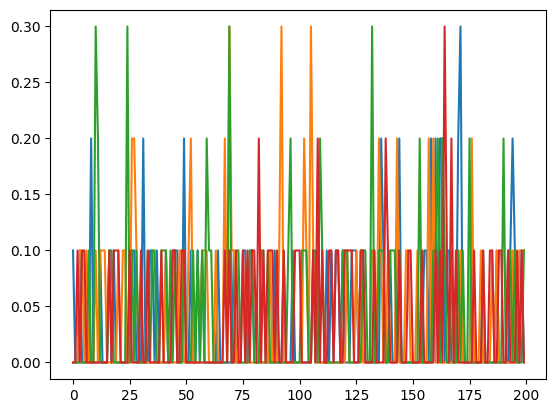

In [43]:
plt.plot(logs[1])
plt.plot(logs[2])
plt.plot(logs[3])
plt.plot(logs[4])
plt.plot(logs[5])

In [7]:
class CartpoleDynamics:
    def __init__(self,
                 timestep=0.02,
                 m_p=0.5,
                 m_c=0.5,
                 l=0.6,
                 g=-9.81,
                 u_range=15):
        """
        Initializes the Cartpole Dynamics model with given parameters.

        Parameters:
        - timestep (float): The time step for the simulation.
        - m_p (float): Mass of the pole.
        - m_c (float): Mass of the cart.
        - l (float): Length of the pole.
        - g (float): Acceleration due to gravity. Negative values indicate direction.
        - u_range (float): Range of the control input.
        """

        self.m_p  = m_p
        self.m_c  = m_c
        self.l    = l
        self.g    = -g
        self.dt   = timestep

        self.u_range = u_range

        self.u_lb = torch.tensor([-1]).float()
        self.u_ub = torch.tensor([1]).float()
        self.q_shape = 4
        self.u_shape = 1

    def _qdotdot(self, q, u):
        """
        Calculates the acceleration of both cart and pole as a function of the current state and control input.

        Parameters:
        - q (torch.Tensor): The current state of the system, [x, theta, xdot, thetadot].
        - u (torch.Tensor): The current control input.

        Returns:
        - torch.Tensor: Accelerations [x_dotdot, theta_dotdot] of the cart and the pole.
        """
        x, theta, xdot, thetadot = q.T

        if len(u.shape) == 2:
            u = torch.flatten(u)

        x_dotdot = (
            u + self.m_p * torch.sin(theta) * (
                self.l * torch.pow(thetadot,2) + self.g * torch.cos(theta)
            )
        ) / (self.m_c + self.m_p * torch.sin(theta)**2)

        theta_dotdot = (
            -u*torch.cos(theta) -
            self.m_p * self.l * torch.pow(thetadot,2) * torch.cos(theta) * torch.sin(theta) -
            (self.m_c + self.m_p) * self.g * torch.sin(theta)
        ) / (self.l * (self.m_c + self.m_p * torch.sin(theta)**2))

        return torch.stack((x_dotdot, theta_dotdot), dim=-1)

    def _euler_int(self, q, qdotdot):
        """
        Performs Euler integration to calculate the new state given the current state and accelerations.

        Parameters:
        - q (torch.Tensor): The current state of the system, [x, theta, xdot, thetadot].
        - qdotdot (torch.Tensor): The accelerations [x_dotdot, theta_dotdot] of the cart and the pole.

        Returns:
        - torch.Tensor: The new state of the system after a single time step.
        """

        qdot_new = q[...,2:] + qdotdot * self.dt
        q_new = q[...,:2] + self.dt * qdot_new

        return torch.cat((q_new, qdot_new), dim=-1)

    def step(self, q, u):
        """
        Performs a single step of simulation given the current state and control input.

        Parameters:
        - q (torch.Tensor or np.ndarray): The current state of the system.
        - u (torch.Tensor or np.ndarray): The current control input.

        Returns:
        - torch.Tensor: The new state of the system after the step.
        """

        # Check for numpy array
        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        scaled_u = u * float(self.u_range)

        # Check for shape issues
        if len(q.shape) == 2:
            q_dotdot = self._qdotdot(q, scaled_u)
        elif len(q.shape) == 1:
            q_dotdot = self._qdotdot(q.reshape(1,-1), scaled_u)
        else:
            raise RuntimeError('Invalid q shape')

        new_q = self._euler_int(q, q_dotdot)

        if len(q.shape) == 1:
            new_q = new_q[0]

        return new_q

    # given q [bs, q_shape] and u [bs, t, u_shape] run the trajectories
    def run_batch_of_trajectories(self, q, u):
        """
        Simulates a batch of trajectories given initial states and control inputs over time.

        Parameters:
        - q (torch.Tensor): Initial states for each trajectory in the batch.
        - u (torch.Tensor): Control inputs for each trajectory over time.

        Returns:
        - torch.Tensor: The states of the system at each time step for each trajectory.
        """
        qs = [q]

        for t in range(u.shape[1]):
            qs.append(self.step(qs[-1], u[:,t]))

        return torch.stack(qs, dim=1)

    # given q [bs, t, q_shape] and u [bs, t, u_shape] calculate the rewards
    def reward(self, q, u):
        """
        Calculates the reward for given states and control inputs.

        Parameters:
        - q (torch.Tensor or np.ndarray): States of the system.
        - u (torch.Tensor or np.ndarray): Control inputs applied.

        Returns:
        - torch.Tensor: The calculated rewards for the states and inputs.
        """

        if isinstance(q, np.ndarray):
            q = torch.from_numpy(q)
        if isinstance(u, np.ndarray):
            u = torch.from_numpy(u)

        angle_term = 0.5*(1-torch.cos(q[...,1]))
        pos_term = -0.5*torch.pow(q[...,0],2)
        ctrl_cost = -0.001*(u**2).sum(dim=-1)

        return angle_term + pos_term + ctrl_cost

class CartpoleGym(gym.Env):
    def __init__(self, timestep_limit=200):
        """
        Initializes the Cartpole environment with a specified time step limit.

        Parameters:
        - timestep_limit (int): The maximum number of timesteps for each episode.

        Sets up the dynamics model and initializes the simulation state.
        """
        self.dynamics = CartpoleDynamics()

        self.timestep_limit = timestep_limit
        self.reset()

    def reset(self):
        """
        Resets the environment to the initial state.

        Returns:
        - np.ndarray: The initial state of the environment.
        """

        self.q_sim = np.zeros(4)
        self.timesteps = 0

        self.traj = [self.get_observation()]

        return self.traj[-1]

    def get_observation(self):
        """
        Retrieves the current state of the environment.

        Returns:
        - np.ndarray: The current state of the simulation.
        """

        return self.q_sim

    def step(self, action):
        """
        Executes one time step within the environment using the given action.

        Parameters:
        - action (np.ndarray): The action to apply for this timestep.

        Returns:
        - Tuple[np.ndarray, float, bool, dict]: A tuple containing the new state, the reward received,
          a boolean indicating whether the episode is done, and an info dictionary.
        """
        action = np.clip(action, self.action_space.low, self.action_space.high)[0]

        new_q = self.dynamics.step(
            self.q_sim, action
        )

        if not isinstance(action, torch.Tensor):
            action = torch.tensor(action)

        reward = self.dynamics.reward(
            new_q, action
        ).numpy()

        self.q_sim = new_q.numpy()
        done = self.is_done()

        self.timesteps += 1

        self.traj.append(self.q_sim)

        return self.q_sim, reward, done, {}

    def is_done(self):
        """
        Checks if the episode has finished based on the timestep limit.

        Returns:
        - bool: True if the episode is finished, False otherwise.
        """
        # Kill trial when too much time has passed
        if self.timesteps >= self.timestep_limit:
            return True

        return False

    def plot_func(self, to_plot, i=None):
        """
        Plots the current state of the cartpole system for visualization.

        Parameters:
        - to_plot (matplotlib.axes.Axes or dict): Axes for plotting or a dictionary of plot elements to update.
        - i (int, optional): The index of the current state in the trajectory to plot.
        """
        def _square(center_x, center_y, shape, angle):
            trans_points = np.array([
                [shape[0], shape[1]],
                [-shape[0], shape[1]],
                [-shape[0], -shape[1]],
                [shape[0], -shape[1]],
                [shape[0], shape[1]]
            ]) @ np.array([
                [np.cos(angle), np.sin(angle)],
                [-np.sin(angle), np.cos(angle)]
            ]) + np.array([center_x, center_y])

            return trans_points[:, 0], trans_points[:, 1]

        if isinstance(to_plot, Axes):
            imgs = dict(
                cart=to_plot.plot([], [], c="k")[0],
                pole=to_plot.plot([], [], c="k", linewidth=5)[0],
                center=to_plot.plot([], [], marker="o", c="k",
                                          markersize=10)[0]
            )

            x_width = max(1,max(np.abs(t[0]) for t in self.traj) * 1.3)

            # centerline
            to_plot.plot(np.linspace(-x_width, x_width, num=50), np.zeros(50),
                         c="k", linestyle="dashed")

            # set axis
            to_plot.set_xlim([-x_width, x_width])
            to_plot.set_ylim([-self.dynamics.l*1.2, self.dynamics.l*1.2])

            return imgs

        curr_x = self.traj[i]

        cart_size = (0.15, 0.1)

        cart_x, cart_y = _square(curr_x[0], 0.,
                                cart_size, 0.)

        pole_x = np.array([curr_x[0], curr_x[0] + self.dynamics.l
                           * np.cos(curr_x[1]-np.pi/2)])
        pole_y = np.array([0., self.dynamics.l
                           * np.sin(curr_x[1]-np.pi/2)])

        to_plot["cart"].set_data(cart_x, cart_y)
        to_plot["pole"].set_data(pole_x, pole_y)
        to_plot["center"].set_data(self.traj[i][0], 0.)

    def render(self, mode="human"):
        """
        Renders the current state of the environment using a matplotlib animation.

        This function creates a matplotlib figure and uses the plot_func method to update the figure with the current
        state of the cartpole system at each timestep. The animation is created with the FuncAnimation class and is
        configured to play at a specified frame rate.

        Parameters:
        - mode (str): The mode for rendering. Currently, only "human" mode is supported, which displays the animation
          on screen.

        Returns:
        - matplotlib.animation.FuncAnimation: The animation object that can be displayed in a Jupyter notebook or
          saved to file.
        """
        self.anim_fig = plt.figure()

        self.axis = self.anim_fig.add_subplot(111)
        self.axis.set_aspect('equal', adjustable='box')

        imgs = self.plot_func(self.axis)
        _update_img = lambda i: self.plot_func(imgs, i)

        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

        ani = FuncAnimation(
            self.anim_fig, _update_img, interval=self.dynamics.dt*1000,
            frames=len(self.traj)-1
        )

        plt.close()

        return ani

    @property
    def action_space(self):
        """
        Defines the action space of the environment using a Box space from OpenAI Gym.

        The action space is defined based on the lower and upper bounds for the control input specified in the
        dynamics model. This allows for a continuous range of actions that can be applied to the cartpole system.

        Returns:
        - gym.spaces.Box: The action space as a Box object, with low and high bounds derived from the dynamics model's
          control input bounds.
        """
        return gym.spaces.Box(low=self.dynamics.u_lb.numpy(), high=self.dynamics.u_ub.numpy())

    @property
    def observation_space(self):
        """
        Defines the observation space of the environment using a Box space from OpenAI Gym.

        The observation space is defined with no bounds on the values, representing the position and velocity of the
        cart and the angle and angular velocity of the pole. This space allows for any real-valued vector of
        positions and velocities to be a valid observation in the environment.

        Returns:
        - gym.spaces.Box: The observation space as a Box object, with low and high bounds set to negative and
          positive infinity, respectively, for each dimension of the state vector.
        """
        return gym.spaces.Box(
            low= np.array([-np.inf, -np.inf, -np.inf, -np.inf]),
            high=np.array([np.inf,   np.inf,  np.inf,  np.inf])
        )

env_name = 'CartpoleSwingUp-v0'
if env_name in registry.env_specs:
    del registry.env_specs[env_name]
register(
    id=env_name,
    entry_point=f'{__name__}:CartpoleGym',
)


NameError: name 'registry' is not defined

In [6]:
env = gym.make('CartpoleSwingUp-v0')

q = env.reset()
done = False
while not done:
    q, r, done, _ = env.step(env.action_space.sample())

env.render()

NameNotFound: Environment CartpoleSwingUp doesn't exist. Did you mean: `CartPole`?